<a href="https://colab.research.google.com/github/lightsixer/P1regression/blob/dev/notebooks/P1_House_Pricing_Predictor_RFR_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

CSCE 5214.002

**Group 13 - Housing Price Predictor Program**

Author: Bradley Davis

**Random Forest Regressor model**

Portions from the following sources:

https://www.datatechnotes.com/2020/09/regression-example-with-randomforestregressor.html

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

train_file_path = "../data/preptrain.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 11)


In [3]:
from sklearn.model_selection import train_test_split
X, y = dataset_df.iloc[:,:-1].values, dataset_df.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_text shape: ', y_test.shape)

X_train shape:  (1168, 10)
y_train shape:  (1168,)
X_test shape:  (292, 10)
y_text shape:  (292,)


Scale the data

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

Training the model

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import set_config

set_config(print_changed_only=False)
rforest = RandomForestRegressor()
# display default random forest configuration
print(rforest)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='squared_error',
                      max_depth=None, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


Fit the model on training data and check accuracy score

In [6]:
rforest.fit(X_train, y_train)

score = rforest.score(X_train, y_train)
print("R-squared: ", score)

R-squared:  0.9737867495777794


Now let's predict the test data and check the accuracy

In [7]:
y_predicted = rforest.predict(X_test)

errors = abs(y_predicted - y_test)
mape = 100 * np.mean(errors/ y_test)
accuracy = 100 - mape
print('Average Error: {:0.4f} dollars.'.format(np.mean(errors)))
print('Accuracy = {:0.2f}%.'.format(accuracy))

Average Error: 19326.6844 dollars.
Accuracy = 88.61%.


Plotting the predicted prices against actual test prices

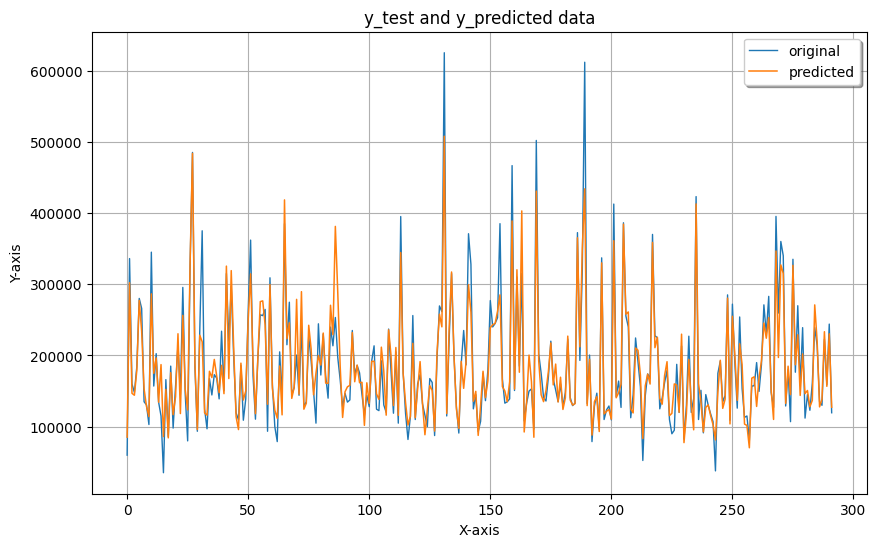

In [8]:
x_ax = range(len(y_test))
plt.figure(figsize=(10, 6))
plt.plot(x_ax, y_test, linewidth=1, label='original')
plt.plot(x_ax, y_predicted, linewidth=1.1, label='predicted')
plt.title('y_test and y_predicted data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()


Hyperparameter tuning via random cross-validation

In [9]:
import pprint
pp = pprint.PrettyPrinter()
print('Parameters currently in use: \n')
pp.pprint(rforest.get_params())

Parameters currently in use: 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


We will focus on the following parameters:

n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap

Here create the parameter grid for tuning:

In [10]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

randomCV_grid = { 'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap}

pp.pprint(randomCV_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


Conduct random search hyperparameter training on the train data. This runs for more than 18 minutes.

In [11]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()
# create a search randomizer for 100 combinations with 3-fold CV
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = randomCV_grid,
                               n_iter = 100, cv = 3, verbose = 2,
                               random_state=0, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='squared_error',
                                                   max_depth=None,
                                                   max_features=1.0,
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                                                   n_jobs=None, oob_score=False,
                                                   random_state=No...
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   pre_dispatch='2*n_jobs', random_state=0, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

Check the accuracy of the randomly found best estimator

In [12]:
# display the best params
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': True}

In [13]:
rforest_best_random = rf_random.best_estimator_
y_predicted_r = rforest_best_random.predict(X_test)

errors = abs(y_predicted_r - y_test)
mape = 100 * np.mean(errors/ y_test)
accuracy = 100 - mape
print('Average Error: {:0.4f} dollars.'.format(np.mean(errors)))
print('Accuracy = {:0.2f}%.'.format(accuracy))

Average Error: 20355.5678 dollars.
Accuracy = 88.31%.


We only achieved a miniscule fraction of a percentage improvement with a randomly search best set of parameters.  

Let's try GridSearchCV anyway within a range around the best random set.

Runs about 14 min.

In [14]:
from sklearn.model_selection import GridSearchCV

# New parameter grid using results of random search
# This should try 1*4*2*3*3*4=288 combinations
param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 80, 90, 100],
    'max_features': [3, 4],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [3, 5, 7],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()

gridCV_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3,
                             n_jobs=-1, verbose=2)
gridCV_search.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='squared_error',
                                             max_depth=None, max_features=1.0,
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [70, 80, 90, 100],
                         'max_features': [3, 4], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': [100, 200, 300, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

Let's check the accuracy of the best grid search estimator...

In [15]:
rforest_best_grid = gridCV_search.best_estimator_

y_predicted_g = rforest_best_grid.predict(X_test)

errors = abs(y_predicted_g - y_test)
mape = 100 * np.mean(errors/ y_test)
accuracy = 100 - mape
print('Average Error: {:0.4f} dollars.'.format(np.mean(errors)))
print('Accuracy = {:0.2f}%.'.format(accuracy))

Average Error: 20231.3696 dollars.
Accuracy = 88.33%.


For random forest regressor with these data features and this grid search criteria it turns out our randomly searched estimator is the most accurate, so we will stick with that one.  We could plot the predictions against targets again, but the difference is so small nothing new would be visible.

Now let's serialize the model to a file for use on the web.  

We are going to export the randomly searched best model as our random forest regressor.

In [16]:
import pickle
import os
pickle.dump(rforest_best_random, open(os.path.join('../models', 'rforest.pkl'), 'wb'), protocol=4)

The exported model file, rforest.pkl, will be saved to our GitHub repository under /models